In [1]:
import os
import numpy as np
from helpers import *
from models import *   
from nan_imputation import impute_nan
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
from load_data import load_lifespan, load_earlylifespan
from nan_imputation import *

In [2]:
repo_root = find_repo_root()
data_path = os.path.join(repo_root, 'Data/Lifespan')
fdict = load_lifespan(data_path)

In [3]:
# Rows to check for missing values (2:4 in zero-based indexing)
rows_to_check = slice(2, 4)  # Rows 2, 3, 4

# Process all arrays in the dictionary
cut_lifespan_dict = {name: cut_array(array, rows_to_check) for name, array in fdict.items()}

In [4]:
for name, item in cut_lifespan_dict.items():
    #print(name)
    print(name.split(sep='_')[2])
    #print(item[:,:10])

control
control
control
control
control
control
control
control
control
control
control
control
companyDrug
companyDrug
companyDrug
companyDrug
companyDrug
companyDrug
companyDrug
companyDrug
companyDrug
companyDrug
companyDrug
companyDrug
controlTerbinafin
controlTerbinafin
controlTerbinafin
controlTerbinafin
controlTerbinafin
controlTerbinafin
controlTerbinafin
controlTerbinafin
controlTerbinafin
controlTerbinafin
controlTerbinafin
controlTerbinafin


In [5]:
lenghts = np.zeros(shape=(len(cut_lifespan_dict), 2))
idx = 0 
for name, item in cut_lifespan_dict.items():
    currname = name.split(sep='_')[2]
    if (currname == 'control') or (currname == 'controlTerbinafin'):
        lenghts[idx,0] = 0
        lenghts[idx, 1] = item.shape[1]
    elif currname == 'companyDrug':
        lenghts[idx,0] = 1
        lenghts[idx, 1] = item.shape[1]
    elif currname == 'Tebrafin':
        lenghts[idx,0] = 2
        lenghts[idx, 1] = item.shape[1]    
    elif currname == 'ATR+':
        lenghts[idx,0] = 3
        lenghts[idx, 1] = item.shape[1]
    elif currname == 'ATR-':
        lenghts[idx,0] = 4
        lenghts[idx, 1] = item.shape[1]
    idx += 1
idx = 0

Text(0.5, 0, 'time $t$')

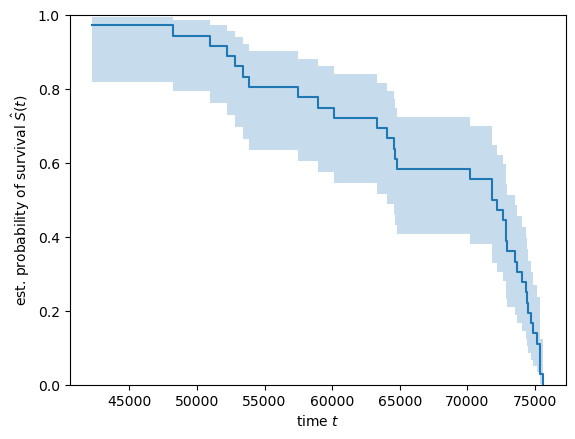

In [6]:
larr = np.array(lenghts[:,1])
stat = np.full(larr.shape, True)
time, survival_prob, conf_int = kaplan_meier_estimator(
    stat, larr, conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [7]:
lenghts[:,1]

array([72932., 70217., 74062., 71822., 64759., 74414., 53396., 72595.,
       52217., 52787., 72216., 75159., 53811., 74307., 75395., 73516.,
       75343., 72844., 73638., 74496., 74855., 74689., 75593., 64534.,
       48238., 58947., 50937., 60114., 75349., 64658., 57462., 64033.,
       72883., 42253., 71833., 63319.])

In [8]:
from isdead import estimate_dying_time
death_times = []
for name, item in cut_lifespan_dict.items():
    print(f'worm name: {name}')
    arrdf = pd.DataFrame(item.T)
    if arrdf.shape[1] == 5:
        arrdf.columns = ['Frame','Speed','X','Y','Changed Pixels']
    else:
        arrdf.columns = ['Frame','Speed','X','Y','Changed Pixels','ATR']
    estimate_dying_time(arrdf, movement_threshold=1.0)
    dying_frame,absolute_frame,dying_time_hours,segment_number = estimate_dying_time(arrdf, movement_threshold=1.0)
    if absolute_frame is not None:
        death_times.append(absolute_frame)
    else:
        death_times.append(arrdf.shape[0])

worm name: worm_1_control
worm name: worm_2_control
worm name: worm_3_control
worm name: worm_4_control
worm name: worm_5_control
worm name: worm_6_control
worm name: worm_7_control
worm name: worm_8_control
worm name: worm_9_control
worm name: worm_10_control
worm name: worm_11_control
worm name: worm_12_control
worm name: worm_13_companyDrug
worm name: worm_14_companyDrug
worm name: worm_15_companyDrug
worm name: worm_16_companyDrug
worm name: worm_17_companyDrug
worm name: worm_18_companyDrug
worm name: worm_19_companyDrug
worm name: worm_20_companyDrug
worm name: worm_21_companyDrug
worm name: worm_22_companyDrug
worm name: worm_23_companyDrug
worm name: worm_24_companyDrug
worm name: worm_25_controlTerbinafin
worm name: worm_26_controlTerbinafin
worm name: worm_27_controlTerbinafin
worm name: worm_28_controlTerbinafin
worm name: worm_29_controlTerbinafin
worm name: worm_30_controlTerbinafin
worm name: worm_31_controlTerbinafin
worm name: worm_32_controlTerbinafin
worm name: worm_3

Text(0.5, 0, 'time $t$')

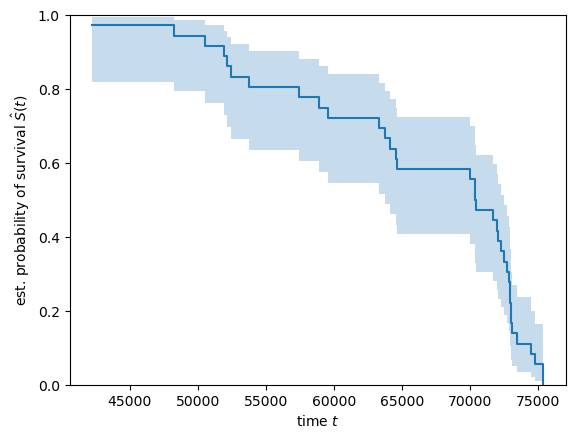

In [9]:
larr = np.array(death_times)
stat = np.full(larr.shape, True)
time, survival_prob, conf_int = kaplan_meier_estimator(
    stat, larr, conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [10]:
np.min(death_times)

np.int64(42228)

In [11]:
y_reg = np.array(death_times)
y_class = np.array(lenghts[:,0].astype(int))

In [66]:
from preprocessing_features import create_aug
samples = []
new_death = []
y_reg_fin = []
seed1 = 2345
seed2 = 58934823
c = 0
for name, item in cut_lifespan_dict.items():
    #print(name)
    #print(item.T[0,1:5])
    arr = item.T[:,1:5]
    f1 = arr[:,0]
    f2 = arr[:,3]
    x = arr[:,1]
    y = arr[:,2]
    #create rotated sample
    rot90arr = np.vstack((f1,y,x,f2))
    x_opp, y_opp = create_aug(x,y,seed=seed1)
    x_opp2, y_opp2 = create_aug(x,y,seed=seed2)
    seed1 += 100
    seed2 -= seed1
    augarr = np.vstack((f1,x_opp,y_opp,f2))
    augarr2 = np.vstack((f1,x_opp2, y_opp2, f2))
    samples.append(arr[:35000])
    #samples.append(rot90arr.T[:35000])
    samples.append(augarr.T[:35000])
    #samples.append(augarr2.T[:35000])
    frame = item.T[:,0:1]
    #print(frame.shape)
    #print(augarr.T.shape)
    dfa = pd.DataFrame(np.hstack((frame, augarr.T)))
    dfa.columns = ['Frame','Speed','X','Y','Changed Pixels']
    y_reg_fin.append(y_reg[c])
    #y_reg_fin.append(y_reg[c])
    dying_frame,absolute_frame,dying_time_hours,segment_number = estimate_dying_time(dfa, movement_threshold=1.0)
    if absolute_frame is not None:
        new_death.append(absolute_frame)
        y_reg_fin.append(absolute_frame)
    else:
        new_death.append(arr.shape[0])
        y_reg_fin.append(arr.shape[0])
        print('ddddd')


    #second augmented
    """
    dfa2 = pd.DataFrame(np.hstack((frame, augarr2.T)))
    dfa2.columns = ['Frame','Speed','X','Y','Changed Pixels']
    dying_frame2,absolute_frame2,dying_time_hours2,segment_number2 = estimate_dying_time(dfa2, movement_threshold=1.0)
    if absolute_frame2 is not None:
        new_death.append(absolute_frame2)
        y_reg_fin.append(absolute_frame2)
    else:
        new_death.append(arr.shape[0])
        y_reg_fin.append(arr.shape[0])
        print('qqqqqq')
    """
    c += 1

ddddd
ddddd
ddddd
ddddd
ddddd
ddddd
ddddd
ddddd
ddddd
ddddd
ddddd
ddddd
ddddd
ddddd
ddddd
ddddd
ddddd
ddddd
ddddd
ddddd
ddddd
ddddd
ddddd
ddddd
ddddd
ddddd


In [67]:
y_reg

array([72671, 69955, 72265, 70316, 64528, 72908, 52450, 71938, 52134,
       51890, 70419, 72462, 53742, 72969, 75350, 73411, 70320, 72055,
       73053, 74439, 74750, 72892, 72996, 64141, 48229, 58901, 50531,
       59529, 75315, 64624, 57452, 63771, 72813, 42228, 71651, 63281])

In [68]:
y_reg_fin = np.array(y_reg_fin)
y_reg_fin

array([72671, 72932, 69955, 70217, 72265, 74062, 70316, 71822, 64528,
       64759, 72908, 74414, 52450, 53396, 71938, 72595, 52134, 52217,
       51890, 52787, 70419, 72216, 72462, 75159, 53742, 53811, 72969,
       74307, 75350, 75395, 73411, 73516, 70320, 75343, 72055, 72844,
       73053, 73638, 74439, 74495, 74750, 74855, 72892, 74689, 72996,
       75593, 64141, 64534, 48229, 48238, 58901, 58947, 50531, 50937,
       59529, 60114, 75315, 75348, 64624, 64658, 57452, 57462, 63771,
       64033, 72813, 72883, 42228, 42253, 71651, 71833, 63281, 63319])

In [59]:
samples[1].shape

(35000, 4)

In [42]:
from preprocessing_features import preprocess_dataset

In [69]:
# Process the dataset
features = list(preprocess_dataset(samples))

# Convert to DataFrame for easier analysis
import pandas as pd
features_df = pd.DataFrame(features[0:54])

print(features_df.head())

     x_mean      x_std  x_min        x_max      x_range  x_skewness  \
0  2.435799  15.403010    0.0  1361.971102  1361.971102   47.621159   
1  2.435799  15.403010    0.0  1361.971102  1361.971102   47.621159   
2  1.984789  15.856520    0.0   936.604212   936.604212   36.753156   
3  1.984789  15.856520    0.0   936.604212   936.604212   36.753156   
4  3.443864  16.391981    0.0  1030.313237  1030.313237   34.921551   

    x_kurtosis      y_mean       y_std       y_min  ...  speed_mean  \
0  3080.540534  403.009036  106.352603   85.323529  ...    2.650058   
1  3080.540534  403.019369  106.357733   85.880307  ...    3.266295   
2  1596.499472  421.470212  111.550450  122.416667  ...    2.617741   
3  1596.499472  421.477779  111.550361  120.134216  ...    3.304130   
4  1540.877873  379.098657  119.809226   64.000000  ...    3.488947   

   speed_std  speed_min    speed_max  speed_range  speed_skewness  \
0  22.203917        0.0  1389.497097  1389.497097       33.711169   
1  22.16

In [ ]:
from isdead import estimate_dying_time
death_times = []
for lifespan in cut_lifespan_dict.items():
    print(f'worm name: {name}')
    arrdf = pd.DataFrame(item.T)
    if arrdf.shape[1] == 5:
        arrdf.columns = ['Frame','Speed','X','Y','Changed Pixels']
    else:
        arrdf.columns = ['Frame','Speed','X','Y','Changed Pixels','ATR']
    estimate_dying_time(arrdf, movement_threshold=1.0)
    dying_frame,absolute_frame,dying_time_hours,segment_number = estimate_dying_time(arrdf, movement_threshold=1.0)
    if absolute_frame is not None:
        death_times.append(absolute_frame)
    else:
        death_times.append(arrdf.shape[0])

In [70]:
len(features)

72

In [71]:
X = pd.DataFrame(features[0:73])

In [33]:
y_reg_f =  np.array([val for val in y_reg for _ in (0, 1)]) #duplicate each element

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y_reg_fin, test_size=0.2, random_state=42)

In [73]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
stdsc.fit(X_train)
X_train_std = stdsc.transform(X_train)
X_test_std = stdsc.transform(X_test)

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model = LinearRegression()
model.fit(X_train, y_train)
y_pred_lr = model.predict(X_test)
print('MAE:', mean_absolute_error(y_test, y_pred_lr))

MAE: 2216.395344701166


In [75]:
y_train_pred = model.predict(X_train)

Text(0.5, 0, 'time $t$')

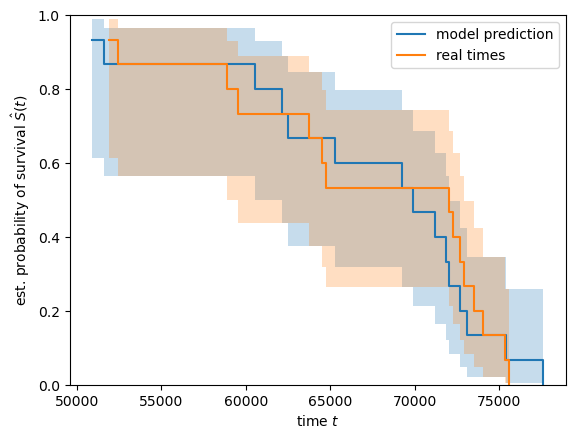

In [76]:
larr = np.array(y_pred_lr)
stat = np.full(larr.shape, True)
time, survival_prob, conf_int = kaplan_meier_estimator(
    stat, larr, conf_type="log-log"
)

larrtr = np.array(y_test)
stattr = np.full(larrtr.shape, True)
time2, survival_prob2, conf_int2 = kaplan_meier_estimator(
    stattr, larrtr, conf_type="log-log"
)

plt.step(time, survival_prob, where="post", label='model prediction')
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.step(time2, survival_prob2, where="post", label='real times')
plt.fill_between(time2, conf_int2[0], conf_int2[1], alpha=0.25, step="post")
plt.legend()
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [50]:
from sklearn.linear_model import Ridge, Lasso

model = Ridge(alpha=1.0)  # Use Lasso(alpha=1.0) for feature selection
model.fit(X_train, y_train)
y_pred_rr = model.predict(X_test)

Text(0.5, 0, 'time $t$')

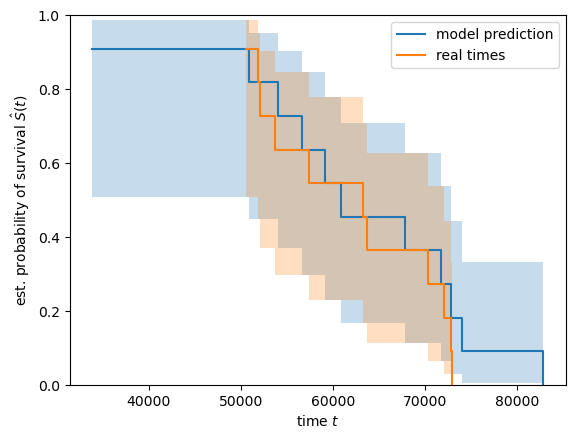

In [40]:
larr = np.array(y_pred_rr)
stat = np.full(larr.shape, True)
time, survival_prob, conf_int = kaplan_meier_estimator(
    stat, larr, conf_type="log-log"
)

larrtr = np.array(y_test)
stattr = np.full(larrtr.shape, True)
time2, survival_prob2, conf_int2 = kaplan_meier_estimator(
    stattr, larrtr, conf_type="log-log"
)

plt.step(time, survival_prob, where="post", label='model prediction')
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.step(time2, survival_prob2, where="post", label='real times')
plt.fill_between(time2, conf_int2[0], conf_int2[1], alpha=0.25, step="post")
plt.legend()
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [85]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=5)
model.fit(X_train_std, y_train)
y_pred_dtr = model.predict(X_test_std)
print('MAE:', mean_absolute_error(y_test, y_pred_dtr))

MAE: 3300.629447181172


In [78]:
y_pred_dtr_tr = model.predict(X_train_std)

Text(0.5, 0, 'time $t$')

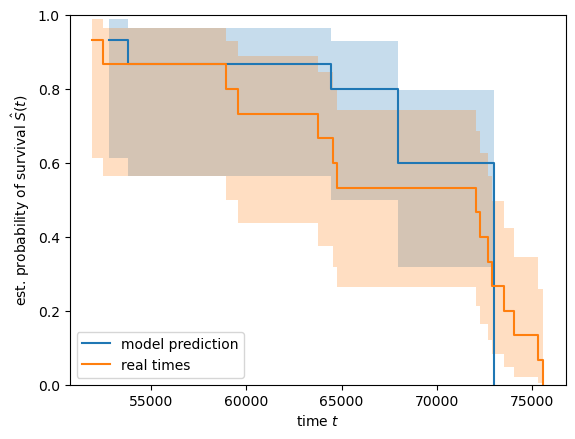

In [79]:
larr = np.array(y_pred_dtr)
stat = np.full(larr.shape, True)
time, survival_prob, conf_int = kaplan_meier_estimator(
    stat, larr, conf_type="log-log"
)

larrtr = np.array(y_test)
stattr = np.full(larrtr.shape, True)
time2, survival_prob2, conf_int2 = kaplan_meier_estimator(
    stattr, larrtr, conf_type="log-log"
)

plt.step(time, survival_prob, where="post", label='model prediction')
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.step(time2, survival_prob2, where="post", label='real times')
plt.fill_between(time2, conf_int2[0], conf_int2[1], alpha=0.25, step="post")
plt.legend()
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [80]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred_rfr = model.predict(X_test)

Text(0.5, 0, 'time $t$')

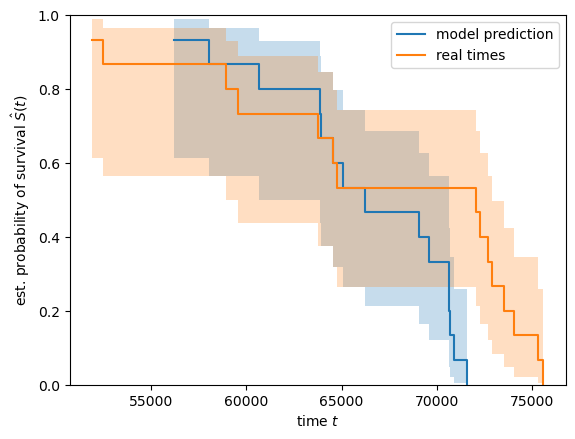

In [81]:
larr = np.array(y_pred_rfr)
stat = np.full(larr.shape, True)
time, survival_prob, conf_int = kaplan_meier_estimator(
    stat, larr, conf_type="log-log"
)

larrtr = np.array(y_test)
stattr = np.full(larrtr.shape, True)
time2, survival_prob2, conf_int2 = kaplan_meier_estimator(
    stattr, larrtr, conf_type="log-log"
)

plt.step(time, survival_prob, where="post", label='model prediction')
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.step(time2, survival_prob2, where="post", label='real times')
plt.fill_between(time2, conf_int2[0], conf_int2[1], alpha=0.25, step="post")
plt.legend()
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [82]:
from sklearn.svm import SVR

model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
model.fit(X_train, y_train)
y_pred_svm = model.predict(X_test)

Text(0.5, 0, 'time $t$')

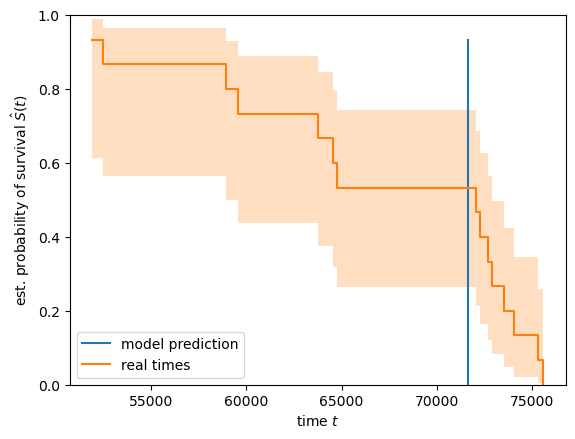

In [83]:
larr = np.array(y_pred_svm)
stat = np.full(larr.shape, True)
time, survival_prob, conf_int = kaplan_meier_estimator(
    stat, larr, conf_type="log-log"
)

larrtr = np.array(y_test)
stattr = np.full(larrtr.shape, True)
time2, survival_prob2, conf_int2 = kaplan_meier_estimator(
    stattr, larrtr, conf_type="log-log"
)

plt.step(time, survival_prob, where="post", label='model prediction')
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.step(time2, survival_prob2, where="post", label='real times')
plt.fill_between(time2, conf_int2[0], conf_int2[1], alpha=0.25, step="post")
plt.legend()
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [42]:
X_train_std[0]

array([ 1.04718728,  1.71702775,  0.        ,  0.74188839,  0.74188839,
       -0.27842463, -0.45090051, -0.97010699,  1.33168636, -0.79155373,
       -1.15778596, -0.52505105,  0.01918012, -1.09703025, -0.95784396,
       -0.87157902,  0.9800869 ,  0.9290007 ,  0.2944793 ,  1.82085028,
        0.49363611,  0.25812309,  1.14074294, -0.14693828, -0.34627357,
        0.58086787, -0.55375872, -0.9296748 , -0.67338976, -0.29643574,
       -0.62641123,  0.36376905, -0.78598026, -0.07088812])

In [43]:
X_train_std[1]

array([-0.43228088, -1.02520547,  0.        , -1.30298337, -1.30298337,
       -1.93810821, -1.3716083 ,  1.47556938, -0.95457385,  1.87828561,
        1.07594758, -1.35633946,  0.66095922, -0.63469342, -0.52335905,
        1.73797596,  1.16642908,  0.10257749, -0.62327295, -1.37516289,
       -0.5321504 , -1.21685537, -1.76907178,  0.1173712 ,  2.20557843,
        1.79829086,  2.55628217,  1.42460306, -0.40291098,  0.57247711,
       -1.02958671,  1.17781614, -0.12241552, -0.66162246])

In [99]:
y_class_f =  np.array([val for val in y_class for _ in (0, 1)]) #duplicate each element
#y_class_f = y_class_f.reshape(-1, 1)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_class_f, test_size=0.2, random_state=42)

(72,)

In [100]:
stdsc.fit(X_train_c)
X_train_std_c = stdsc.transform(X_train_c)
X_test_std_c = stdsc.transform(X_test_c)

In [101]:
from sklearn.linear_model import LogisticRegression

lrclass = LogisticRegression()
lrclass.fit(X_train_std_c, y_train_c)
y_pred_c = lrclass.predict(X_test_std_c)

In [102]:
from sklearn.metrics import f1_score, confusion_matrix
f1lr = f1_score(y_test_c, y_pred_c)
print(confusion_matrix(y_test_c, y_pred_c))
print(f'f-1 score: {f1lr}')

[[8 2]
 [3 2]]
f-1 score: 0.4444444444444444
